# Libraries

In [787]:
# import libraries

import os
import math
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.regularizers import l2
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, roc_auc_score

# Functions

In [788]:
# unpickle the files
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [789]:
# load all CIFAR
def load_CIFAR10():

    train_images = np.zeros((50000, 32, 32, 3), dtype=np.uint8)
    train_labels = np.zeros((50000,), dtype=np.uint8)
    
    # get training data
    for i in range(5):
        train_dict = unpickle(f'./data/cifar-10-batches-py/data_batch_{i+1}')
        train_images[i*10000:(i+1)*10000] = train_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        train_labels[i*10000:(i+1)*10000] = train_dict[b'labels']

    # get testing data
    test_dict = unpickle('./data/cifar-10-batches-py/test_batch')
    test_images = test_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    val_labels = np.array(test_dict[b'labels'])

    # convert from integers to floats
    train_images = train_images.astype('float32')
    test_images = test_images.astype('float32')

    # scale image pixels to [0, 1]
    train_images, test_images = train_images / 255.0, test_images / 255.0

    # one hot encode target labels
    train_labels = to_categorical(train_labels)
    val_labels = to_categorical(val_labels)

    return ((train_images, train_labels), (test_images, val_labels))

In [790]:
def load_MNIST():
    (train_X, train_Y), (test_X, test_Y) = mnist.load_data()

    # scale image pixels to [0, 1]
    train_X, test_X = train_X / 255.0, test_X / 255.0

    # one hot encode target labels
    train_Y = to_categorical(train_Y)
    test_Y = to_categorical(test_Y)

    return (train_X, train_Y), (test_X, test_Y)

In [791]:
def load_Cho():

    # import cho dataset
    cols = ['Gene_ID', 'Ground_Truth_Cluster_ID', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16']
    df_cho = pd.read_csv('./data/cho.txt', sep="	", names=cols, header=None)

    # split to 20% test set
    df_train, df_test = train_test_split(df_cho, test_size=0.2)

    # extract labels
    test_labels = df_test.iloc[:, 1].values

    # one hot encode target labels
    test_labels = to_categorical(test_labels)

    # remove first column (label 0, which is not used)
    test_labels = np.delete(test_labels, 0, axis=1)

    # reshape test for CNN
    test = np.reshape(df_test.values.astype('float32'), (df_test.shape[0], 3, 6, 1))

    return df_train, df_test, test, test_labels

In [792]:
def validation_CIFAR(images, labels):
    images, images_val, labels, labels_val = train_test_split(images, labels, test_size=0.1)

    print(f"New training/labels length: {len(images)}/{len(labels)}")
    print(f"New validation/labels length: {len(images_val)}/{len(labels_val)}")
    
    return ((images, labels), (images_val, labels_val))

In [793]:
def validation_MNIST(images, labels):
    images, images_val, labels, labels_val = train_test_split(images, labels, test_size=0.1)

    print(f"New training/labels length: {len(images)}/{len(labels)}")
    print(f"New validation/labels length: {len(images_val)}/{len(labels_val)}")
    
    return ((images, labels), (images_val, labels_val))

In [794]:
def validation_Cho(df, k):
    kf = KFold(n_splits=k, shuffle=True)
 
    # extract the fold
    for train_index, test_index in kf.split(df):
        train_data = df.iloc[train_index].values
        train_labels = df.iloc[train_index]
        val_data = df.iloc[test_index].values
        val_labels = df.iloc[test_index]

    # reshape data for CNN
    train_data = np.reshape(train_data.astype('float32'), (train_data.shape[0], 3, 6, 1))
    val_data = np.reshape(val_data.astype('float32'), (val_data.shape[0], 3, 6, 1))

    # extract labels
    train_labels = train_labels.iloc[:, 1].values
    val_labels = val_labels.iloc[:, 1].values

    # one hot encode target labels
    train_labels = to_categorical(train_labels)
    val_labels = to_categorical(val_labels)
    
    # remove first column (label 0, which is not used)
    train_labels = np.delete(train_labels, 0, axis=1)
    val_labels = np.delete(val_labels, 0, axis=1)

    print(f"New training/labels length: {len(train_data)}/{len(train_labels)}")
    print(f"New validation/labels length: {len(val_data)}/{len(val_labels)}")
    
    return (train_data, train_labels), (val_data, val_labels)

In [795]:
# (shape of the data, and the number of labels)
def build_model_CNN_baseline(shape, labels_size):
   
    # baseline 1-block VGG-style model
    model = models.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(labels_size, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # show summary 
    model.summary()
    return model

In [796]:
# (shape of the data, and the number of labels)
def build_model_CNN_tuned(shape, labels_size):

    # baseline 1-block VGG-style model + drop regularization + batch normalization
    model = models.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(labels_size, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # show summary 
    #model.summary()
    return model

In [797]:
def verify_CIFAR(data, labels):

    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        # show img
        plt.imshow(data[i], cmap=plt.cm.binary)
        
        # show label
        index = np.argmax(labels[i]).astype(int) # needed after one-hot encoding
        plt.xlabel(class_names[index])
        
    plt.show()

In [798]:
def verify_MNIST(data, labels):
    for i in range(9):  
        plt.subplot(330 + 1 + i)
        plt.imshow(data[i], cmap=plt.get_cmap('gray'))
        plt.show()

In [799]:
# plot diagnostic learning curves (History object, string data name, and string indicating validaiton or test set)
# graph showing loss & accuracy over the number of epochs
def show_diagnostics(history, dataset_name, val_or_test):

    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label=val_or_test)
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label=val_or_test)
    
    # adjust visuals
    plt.suptitle('CNN - ' + dataset_name)
    plt.subplots_adjust(hspace=0.5)
    plt.legend()

    # save plot to file
    plt.show()
    #filename = os.getcwd()
    #plt.savefig(filename + '_' + dataset_name + '_evaluation.png')
    plt.close()

In [800]:
def normalize_Cho(df):
    # normalize dataset

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    # PCA with n = 3
    pca = PCA(n_components=3).fit(scaled_data)
    print('Explained Variance Ratio: ', pca.explained_variance_ratio_)
    print('Sum of variance by these 3 components: ', pca.explained_variance_ratio_.cumsum()[2])
    print('\nSingular Values: ', pca.singular_values_)

    df_3D = pca.transform(scaled_data)

    return df_3D

# Run on CIFAR-10

In [801]:
def run_CIFAR10(epoch, batch):
    (train_data, train_labels), (test_data, test_labels) = load_CIFAR10()

    print("\nVerifying Data...")

    verify_CIFAR(train_data, train_labels)

    print("Data Verified!\n")
    print("------------------------------------------------------------------")
    print("Creating Validation Set...")

    (train_data, train_labels), (validation_data, validation_labels) = validation_CIFAR(train_data, train_labels)

    print("Validation Set Created!\n")
    print("------------------------------------------------------------------")
    print("Building Model...")

    model_CIFAR = build_model_CNN_tuned((32, 32, 3), 10)

    print("Model Built!\n")
    print("------------------------------------------------------------------")
    print("Fitting Model...")

    history_CIFAR10 = model_CIFAR.fit(train_data, train_labels, epochs=epoch, batch_size=batch, validation_data=(validation_data, validation_labels), verbose=0)

    print("Model Fitted!\n")

    # show learning curves
    show_diagnostics(history_CIFAR10, "CIFAR-10", "validation")

    print("------------------------------------------------------------------")
    print("Evaluating Model...")

    # evaluate model
    test_loss, test_acc = model_CIFAR.evaluate(test_data,  test_labels)
    print("Loss: ", test_loss)
    print(f"Accuracy: {test_acc :.2%}") # 45.07%

    # make prediction of test set
    pred_labels = model_CIFAR.predict(test_data)

    # visualize first 9 images in test set with their predicted and true labels
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    for i, ax in enumerate(axs.flat):
        ax.imshow(test_data[i])
        ax.set_xticks([])
        ax.set_yticks([])
        index = np.argmax(test_labels[i]).astype(int) # needed after one-hot encoding
        ax.set_title("Ground Truth: {}\nPredicted: {}".format(class_names[index], class_names[np.argmax(pred_labels[i])]))
    plt.show()
    
    print("\nRun Complete!\n")
    return

print('Iteration 1:') # 10 epochs, 64 batch size
#run_CIFAR10(2, 64) #debug

""" print('Iteration 2:') # 20 epochs, 64 batch size
run_CIFAR10() """

Iteration 1:


" print('Iteration 2:') # 20 epochs, 64 batch size\nrun_CIFAR10() "

# Run on MNIST

In [802]:
def run_MNIST(epoch, batch):
    # load dataset
    (train_images, train_labels), (test_images, test_labels) = load_MNIST()

    print("\nVerifying Data...")

    #verify_MNIST(train_images, train_labels)

    print("Data Verified!\n")
    print("------------------------------------------------------------------")
    print("Creating Validation Set...")

    (train_images, train_labels), (validation_images, validation_labels) = validation_CIFAR(train_images, train_labels)

    print("Validation Set Created!\n")
    print("------------------------------------------------------------------")
    print("Building Model...")

    model_MNIST_tuned = build_model_CNN_tuned((28, 28, 1), 10)

    print("Model Built!\n")
    print("------------------------------------------------------------------")
    print("Fitting Model...")

    # fit model
    history_MNIST_tuned = model_MNIST_tuned.fit(train_images, train_labels, epochs=epoch, batch_size=batch, validation_data=(validation_images, validation_labels), verbose=0)

    # show learning curves
    show_diagnostics(history_MNIST_tuned, "MNIST", "test")

    print("Model Fitted!\n")
    print("------------------------------------------------------------------")
    print("Evaluating Model...")

    # evaluate model
    test_loss, test_acc = model_MNIST_tuned.evaluate(test_images,  test_labels)
    print("Loss: ", test_loss)
    print(f"Accuracy: {test_acc :.2%}")

    # make prediction of test set
    pred_labels = model_MNIST_tuned.predict(test_images)

    # visualize first 9 images in test set with their predicted and true labels
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    for i, ax in enumerate(axs.flat):
        ax.imshow(test_images[i])
        ax.set_xticks([])
        ax.set_yticks([])
        index = np.argmax(test_labels[i]).astype(int) # needed after one-hot encoding
        ax.set_title("Ground Truth: {}\nPredicted: {}".format(index, np.argmax(pred_labels[i])))
    plt.show()

    print("\nRun Complete!\n")

print('Iteration 1:') # 10 epochs, 64 batch size
#run_MNIST(2, 64) #debug

Iteration 1:


# Run on Cho


Verifying Data...
Training: 
     Gene_ID  Ground_Truth_Cluster_ID     A1    A2    A3    A4    A5    A6  \
326      327                        4 -0.600 -0.55  0.01  0.61  0.77  0.60   
262      263                        3  0.630 -0.09 -0.51  0.12  0.66  0.32   
206      207                        3 -0.840 -0.48  0.45  0.83  0.97  0.75   
362      363                        5 -0.400 -0.99 -1.06 -0.75 -0.61 -0.76   
137      138                        2 -0.390 -0.16  0.47  0.11  0.11 -0.16   
..       ...                      ...    ...   ...   ...   ...   ...   ...   
148      149                        2 -0.543  0.68  0.73 -0.46 -0.66 -0.16   
323      324                        4 -0.970  0.46  0.01 -0.40 -0.45  0.39   
357      358                        5 -0.540 -0.47 -0.40 -0.28 -0.18 -0.01   
43        44                        1 -0.260  0.33 -0.38 -0.13  0.00 -0.47   
4          5                        1 -1.040  0.13  0.51 -0.44 -0.88 -0.32   

       A7    A8    A9   A10   A11

c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


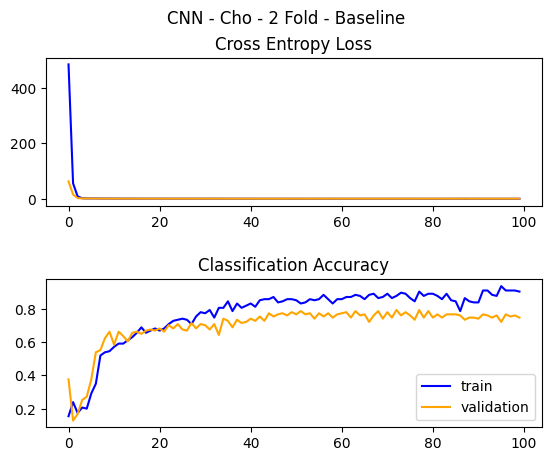

------------------------------------------------------------------
Evaluating Model...
5/5 [==============================] - 0s 3ms/step - loss: 0.7170 - accuracy: 0.7468
Loss:  0.7169525623321533
Accuracy: 74.68%
Evaluated Model!
------------------------------------------------------------------
Predicting...
3/3 [==============================] - 0s 3ms/step - loss: 0.8531 - accuracy: 0.6795
Accuracy: 67.95%
F1 Score: 16.08%
AUC Score: 93.48%
Fold 2 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 206/206
New validation/labels length: 102/102
------------------------------------------------------------------
Building Model...
Model: "sequential_201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_407 (Conv2D)         (None, 3, 6, 32)          320       
                                                          

c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


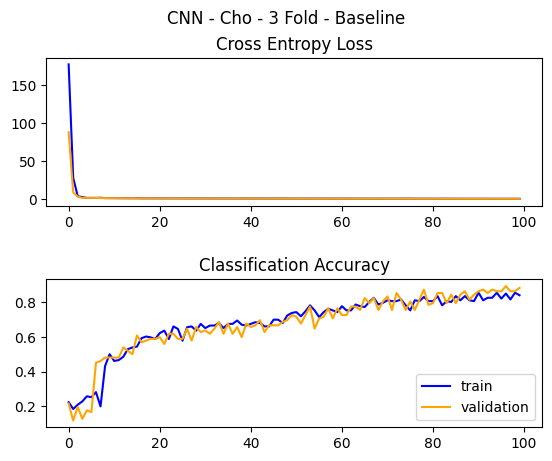

------------------------------------------------------------------
Evaluating Model...
4/4 [==============================] - 0s 3ms/step - loss: 0.4098 - accuracy: 0.8824
Loss:  0.4097563922405243
Accuracy: 88.24%
Evaluated Model!
------------------------------------------------------------------
Predicting...
3/3 [==============================] - 0s 3ms/step - loss: 0.5440 - accuracy: 0.7179
Accuracy: 71.79%
F1 Score: 12.38%
AUC Score: 95.22%
Fold 3 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 231/231
New validation/labels length: 77/77
------------------------------------------------------------------
Building Model...
Model: "sequential_202"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_409 (Conv2D)         (None, 3, 6, 32)          320       
                                                            

c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


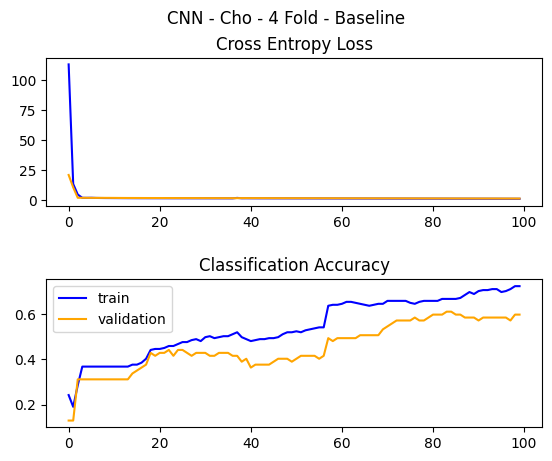

------------------------------------------------------------------
Evaluating Model...
3/3 [==============================] - 0s 3ms/step - loss: 0.9810 - accuracy: 0.5974
Loss:  0.9810330271720886
Accuracy: 59.74%
Evaluated Model!
------------------------------------------------------------------
Predicting...
3/3 [==============================] - 0s 4ms/step - loss: 0.9050 - accuracy: 0.6282
Accuracy: 62.82%
F1 Score: 7.60%
AUC Score: 90.93%
Fold 4 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 247/247
New validation/labels length: 61/61
------------------------------------------------------------------
Building Model...
Model: "sequential_203"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_411 (Conv2D)         (None, 3, 6, 32)          320       
                                                             

c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


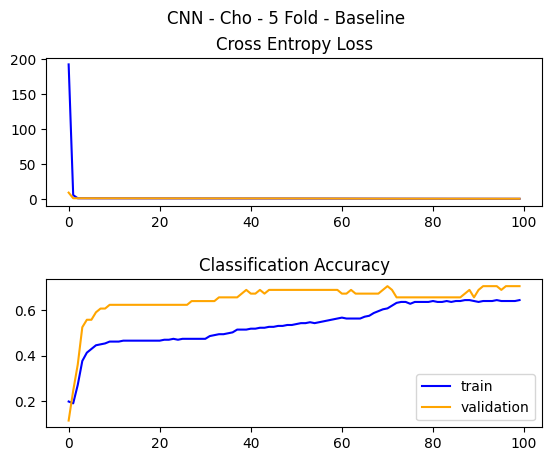

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 5ms/step - loss: 0.9404 - accuracy: 0.7049
Loss:  0.9403542876243591
Accuracy: 70.49%
Evaluated Model!
------------------------------------------------------------------
Predicting...
3/3 [==============================] - 0s 3ms/step - loss: 1.1972 - accuracy: 0.4615
Accuracy: 46.15%
F1 Score: 14.94%
AUC Score: 83.16%
Fold 5 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 257/257
New validation/labels length: 51/51
------------------------------------------------------------------
Building Model...
Model: "sequential_204"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_413 (Conv2D)         (None, 3, 6, 32)          320       
                                                            

c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


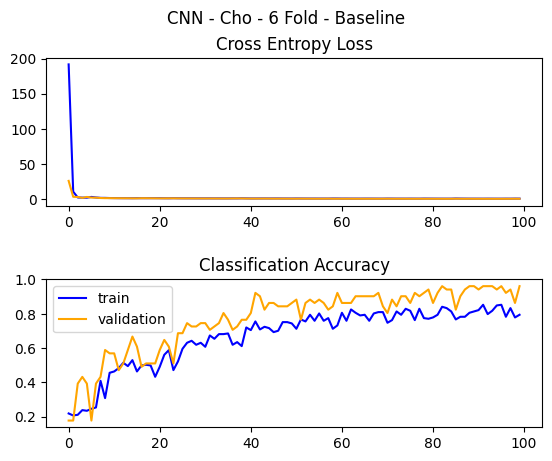

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 7ms/step - loss: 0.2392 - accuracy: 0.9608
Loss:  0.23924052715301514
Accuracy: 96.08%
Evaluated Model!
------------------------------------------------------------------
Predicting...
3/3 [==============================] - 0s 5ms/step - loss: 0.4272 - accuracy: 0.8462
Accuracy: 84.62%
F1 Score: 10.46%
AUC Score: 97.26%
Fold 6 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 154/154
New validation/labels length: 154/154
------------------------------------------------------------------
Building Model...
------------------------------------------------------------------
Fitting Model...


c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


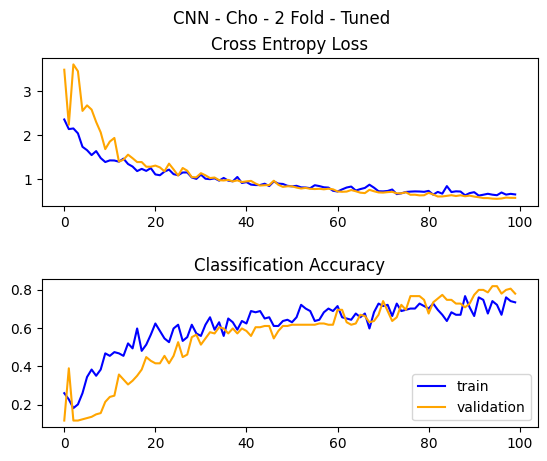

------------------------------------------------------------------
Evaluating Model...
5/5 [==============================] - 0s 3ms/step - loss: 0.5754 - accuracy: 0.7792
Loss:  0.5754299163818359
Accuracy: 77.92%
Evaluated Model!
------------------------------------------------------------------
Predicting...
3/3 [==============================] - 0s 5ms/step - loss: 0.5695 - accuracy: 0.7179
Accuracy: 71.79%
F1 Score: 11.36%
AUC Score: 98.67%
Fold 2 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 206/206
New validation/labels length: 102/102
------------------------------------------------------------------
Building Model...
------------------------------------------------------------------
Fitting Model...


c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


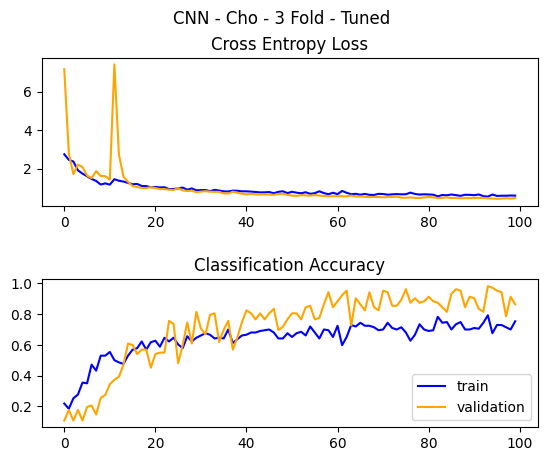

------------------------------------------------------------------
Evaluating Model...
4/4 [==============================] - 0s 4ms/step - loss: 0.4732 - accuracy: 0.8627
Loss:  0.4731661081314087
Accuracy: 86.27%
Evaluated Model!
------------------------------------------------------------------
Predicting...
3/3 [==============================] - 0s 4ms/step - loss: 0.4985 - accuracy: 0.7692
Accuracy: 76.92%
F1 Score: 19.79%
AUC Score: 98.66%
Fold 3 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 231/231
New validation/labels length: 77/77
------------------------------------------------------------------
Building Model...
------------------------------------------------------------------
Fitting Model...


c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


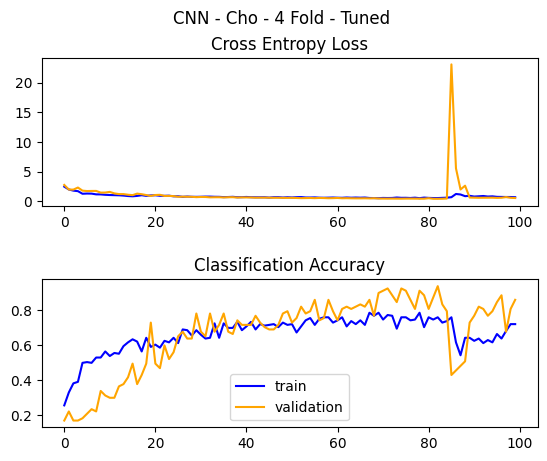

------------------------------------------------------------------
Evaluating Model...
3/3 [==============================] - 0s 4ms/step - loss: 0.5413 - accuracy: 0.8571
Loss:  0.5412710309028625
Accuracy: 85.71%
Evaluated Model!
------------------------------------------------------------------
Predicting...
3/3 [==============================] - 0s 5ms/step - loss: 0.5672 - accuracy: 0.7692
Accuracy: 76.92%
F1 Score: 14.68%
AUC Score: 99.84%
Fold 4 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 247/247
New validation/labels length: 61/61
------------------------------------------------------------------
Building Model...
------------------------------------------------------------------
Fitting Model...


c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


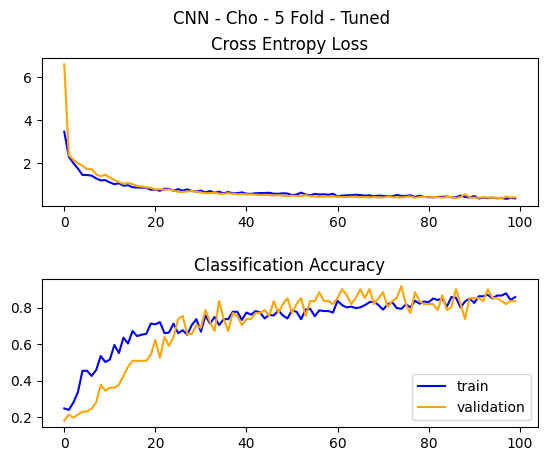

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 7ms/step - loss: 0.3971 - accuracy: 0.8361
Loss:  0.39707860350608826
Accuracy: 83.61%
Evaluated Model!
------------------------------------------------------------------
Predicting...
3/3 [==============================] - 0s 5ms/step - loss: 0.3280 - accuracy: 0.9103
Accuracy: 91.03%
F1 Score: 8.44%
AUC Score: 98.39%
Fold 5 Complete!
------------------------------------------------------------------
Creating Validation Set...
New training/labels length: 257/257
New validation/labels length: 51/51
------------------------------------------------------------------
Building Model...


c:\Users\z1297\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


------------------------------------------------------------------
Fitting Model...


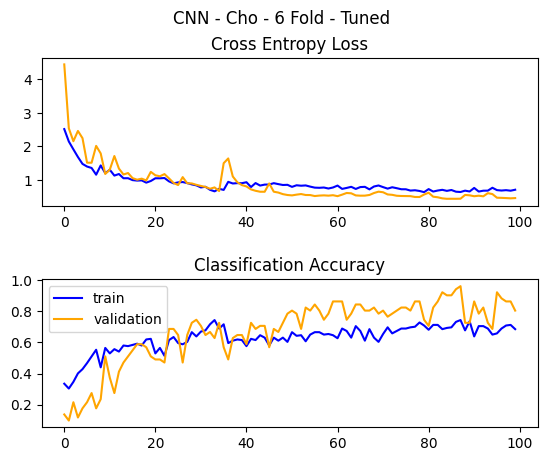

------------------------------------------------------------------
Evaluating Model...
2/2 [==============================] - 0s 8ms/step - loss: 0.4611 - accuracy: 0.8039
Loss:  0.46106988191604614
Accuracy: 80.39%
Evaluated Model!
------------------------------------------------------------------
Predicting...
3/3 [==============================] - 0s 4ms/step - loss: 0.4907 - accuracy: 0.7821
Accuracy: 78.21%
F1 Score: 8.65%
AUC Score: 95.66%
Fold 6 Complete!
------------------------------------------------------------------


In [803]:
#def run_Cho(epochs, batch):
#debug
epochs = 100
batch = 32

# load dataset
df_train, df_test, test, test_labels = load_Cho()

print("\nVerifying Data...")

print("Training: ")
print(df_train)
print("Testing: ")
print(df_test)

print("Data Verified!\n")
print("------------------------------------------------------------------")

# 6 fold cross-validation, 2 times
# First 6 folds are baselines and second 6 folds are tuned models
# both baseline and tuned models run from epochs 20 - 25
model_Cho = {}
for j in range(1,3): # 2 iterations
    for i in range(2,7):
        print("Creating Validation Set...")

        if (i > 1): # skip k=1, 1-fold cross-validation
            (train_data, train_labels), (val_data, val_labels) = validation_Cho(df_train, i)

        print("------------------------------------------------------------------")
        print("Building Model...")

        if (j == 1):
            model_Cho[i] = build_model_CNN_baseline((3, 6, 1), 5) # 6 labels bcuz 0-5, but 0 is not used!
        else:
            model_Cho[i] = build_model_CNN_tuned((3, 6, 1), 5)

        print("------------------------------------------------------------------")
        print("Fitting Model...")

        # fit model
        history_Cho = model_Cho[i].fit(train_data, train_labels, epochs=epochs, batch_size=batch, validation_data=(val_data, val_labels), verbose=0)
        
        # show learning curves
        if (j == 1):
            show_diagnostics(history_Cho, "Cho - " + str(i) + " Fold - Baseline", "validation")
        else:
            show_diagnostics(history_Cho, "Cho - " + str(i) + " Fold - Tuned", "validation")

        print("------------------------------------------------------------------")
        print("Evaluating Model...")

        # evaluate model
        test_loss, test_acc = model_Cho[i].evaluate(val_data,  val_labels)
        print("Loss: ", test_loss)
        print(f"Accuracy: {test_acc :.2%}")
        
        print("Evaluated Model!")
        print("------------------------------------------------------------------")
        print("Predicting...")

        # predict labels
        pred_labels = model_Cho[i].predict(test) # choose best model by index
        df_pred = np.argmax(pred_labels, axis=1)

        # evaluate model
        _, acc = model_Cho[i].evaluate(test,  test_labels)
        f1 = f1_score(df_test.Ground_Truth_Cluster_ID, df_pred, average='macro')
        auc = roc_auc_score(df_test.Ground_Truth_Cluster_ID, pred_labels, multi_class='ovo')

        print(f"Accuracy: {acc :.2%}")
        print(f"F1 Score: {f1 :.2%}")
        print(f"AUC Score: {auc :.2%}")

        print(f"Fold {i} Complete!")
        print("------------------------------------------------------------------")

#run_Cho()

# Predict Cho
Choose the best fitting model from model_Cho[]

In [804]:
# find best model's index
print(model_Cho)

{2: <keras.engine.sequential.Sequential object at 0x000001F55DB21E90>, 3: <keras.engine.sequential.Sequential object at 0x000001F573A00710>, 4: <keras.engine.sequential.Sequential object at 0x000001F5686FB010>, 5: <keras.engine.sequential.Sequential object at 0x000001F564D06650>, 6: <keras.engine.sequential.Sequential object at 0x000001F56F262CD0>}


3/3 [==============================] - 0s 3ms/step
Explained Variance Ratio:  [0.35857933 0.23887212 0.13516636]
Sum of variance by these 3 components:  0.732617810716813

Singular Values:  [22.4375886  18.31328639 13.77583268]


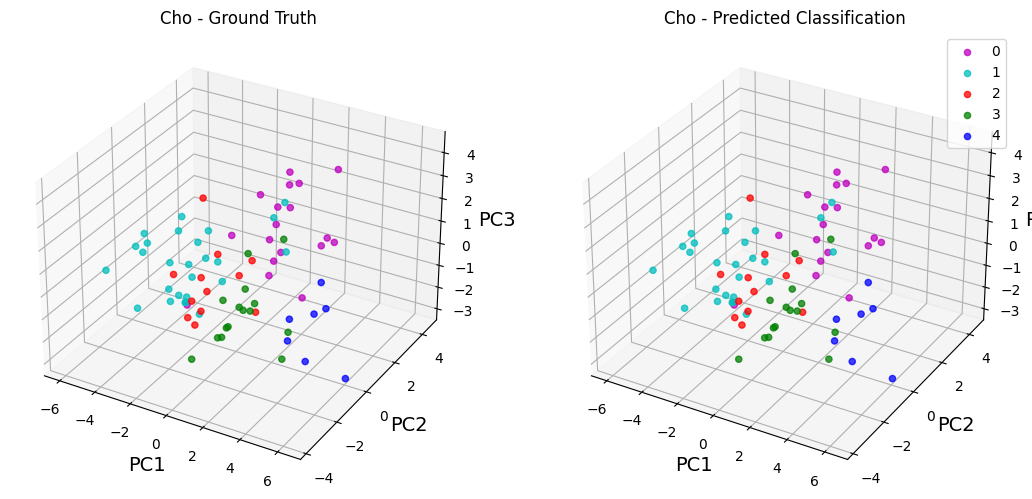

In [808]:
# predict labels
pred_labels = model_Cho[5].predict(test) # choose best model by index
df_pred = np.argmax(pred_labels, axis=1)

# normalize data for plotting
df_test_3D = normalize_Cho(df_test)

# set 3 axis
Xax = df_test_3D[:,0]
Yax = df_test_3D[:,1]
Zax = df_test_3D[:,2]

# create figure variables
fig = plt.figure(figsize=(20,20), constrained_layout=False)
ax_truth = fig.add_subplot(1,3,1, projection='3d')
ax_pred = fig.add_subplot(1,3,2, projection='3d')
fig.patch.set_facecolor('white')
cdict = {0:'m', 1:'c', 2:'r', 3:'g', 4:'b', 5:'y'}
y = df_test.Ground_Truth_Cluster_ID - 1 # minus 1 to compensate for prediction labels being 0-4

# ground truth figure
for l in np.unique(y):
    i = np.where(y==l)
    ax_truth.scatter(Xax[i], Yax[i], Zax[i], c=cdict[l], s=20, alpha=0.75, label=l)

ax_truth.set_xlabel("PC1", fontsize=14)
ax_truth.set_ylabel("PC2", fontsize=14)
ax_truth.set_zlabel("PC3", fontsize=14)
ax_truth.set_title('Cho - Ground Truth')

# predicted figure
for l in np.unique(df_pred):
    i = np.where(y==l)
    ax_pred.scatter(Xax[i], Yax[i], Zax[i], c=cdict[l], s=20, alpha=0.75, label=l)

ax_pred.set_xlabel("PC1", fontsize=14)
ax_pred.set_ylabel("PC2", fontsize=14)
ax_pred.set_zlabel("PC3", fontsize=14)
ax_pred.set_title('Cho - Predicted Classification')

plt.legend()
plt.show()
plt.close()